In [1]:
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_32x32.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.005
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 5

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


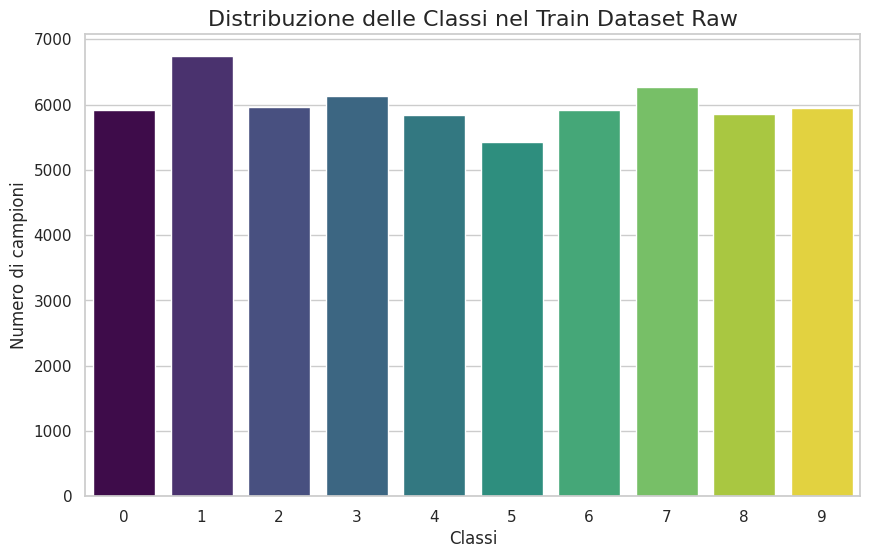

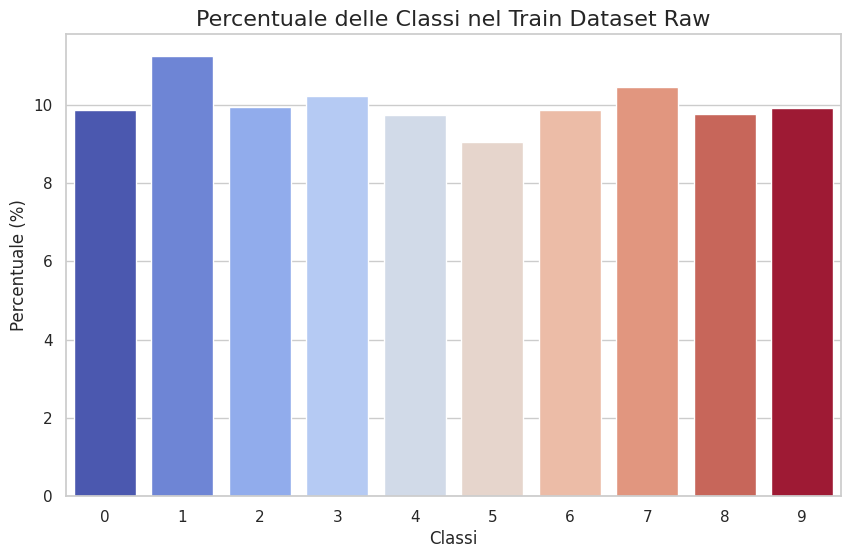

In [3]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




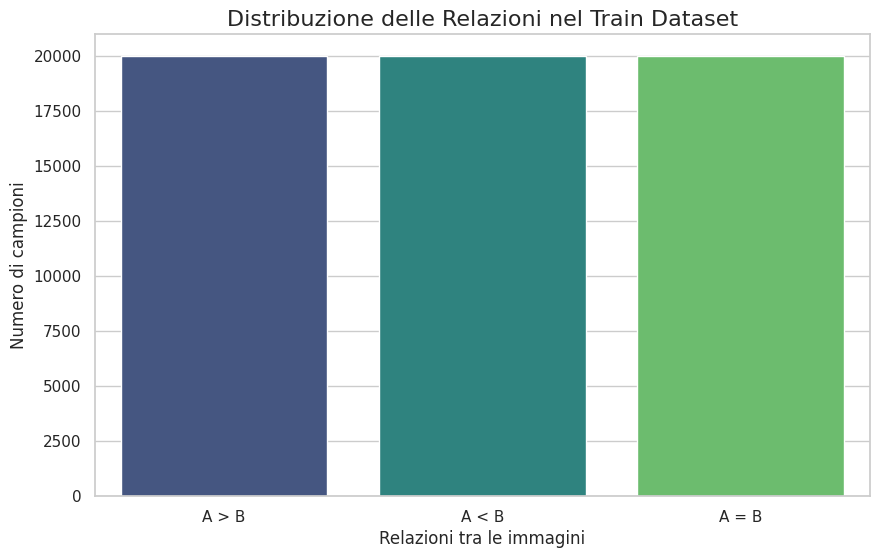

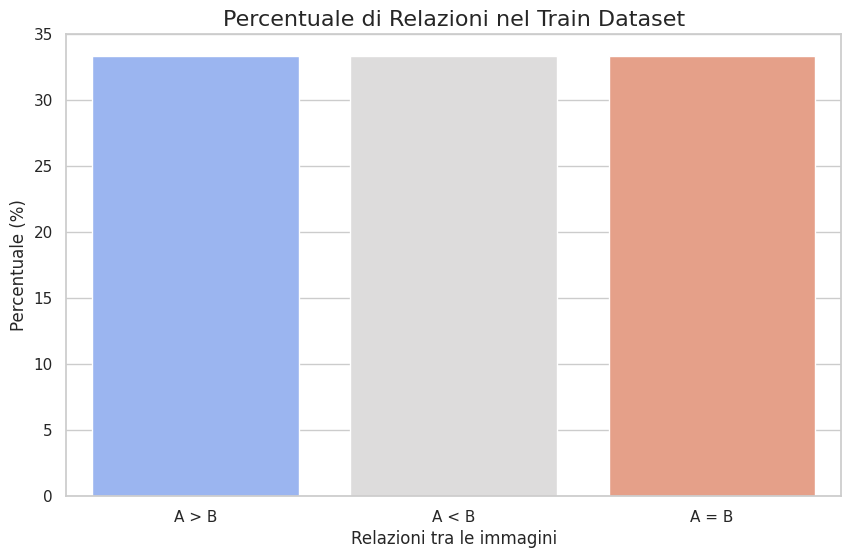

In [4]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 990, 2: 1021, 0: 989}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 1: 990 campioni (33.00%)
Relazione 2: 1021 campioni (34.03%)
Relazione 0: 989 campioni (32.97%)




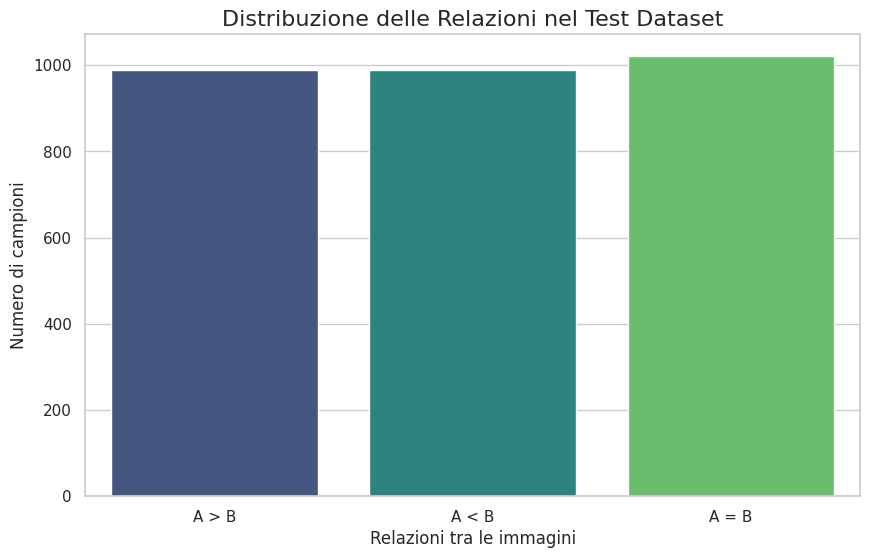

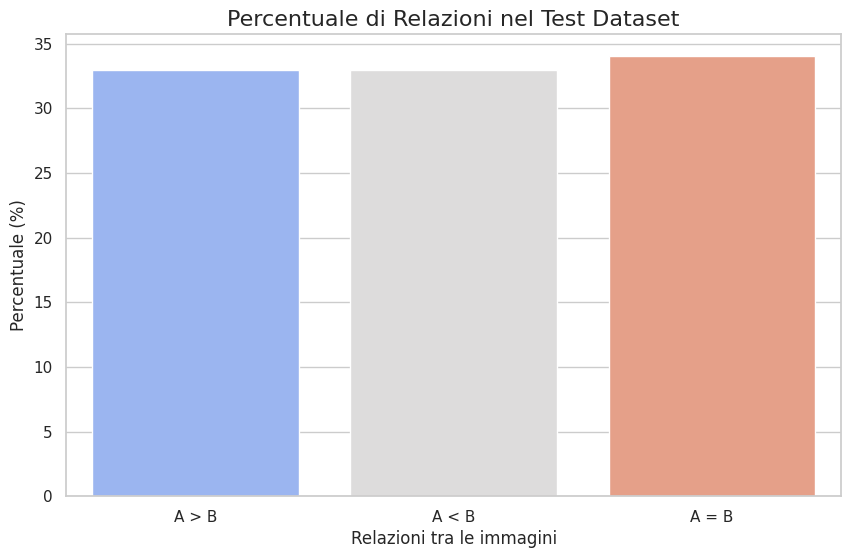

In [5]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2344, 1: 2343, 2: 2312}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2344 campioni (33.49%)
Relazione 1: 2343 campioni (33.48%)
Relazione 2: 2312 campioni (33.03%)




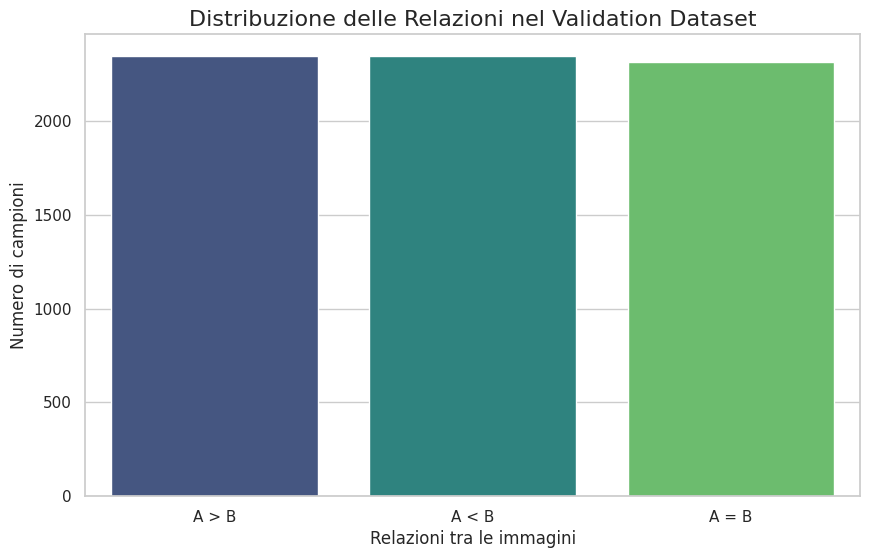

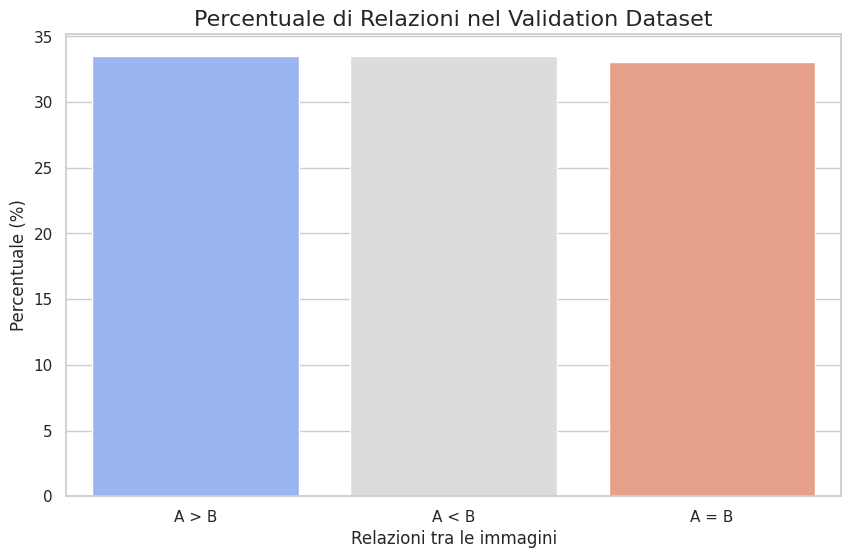

In [6]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [7]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [8]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [11]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

images dtype: torch.float32, labels dtype: torch.int64


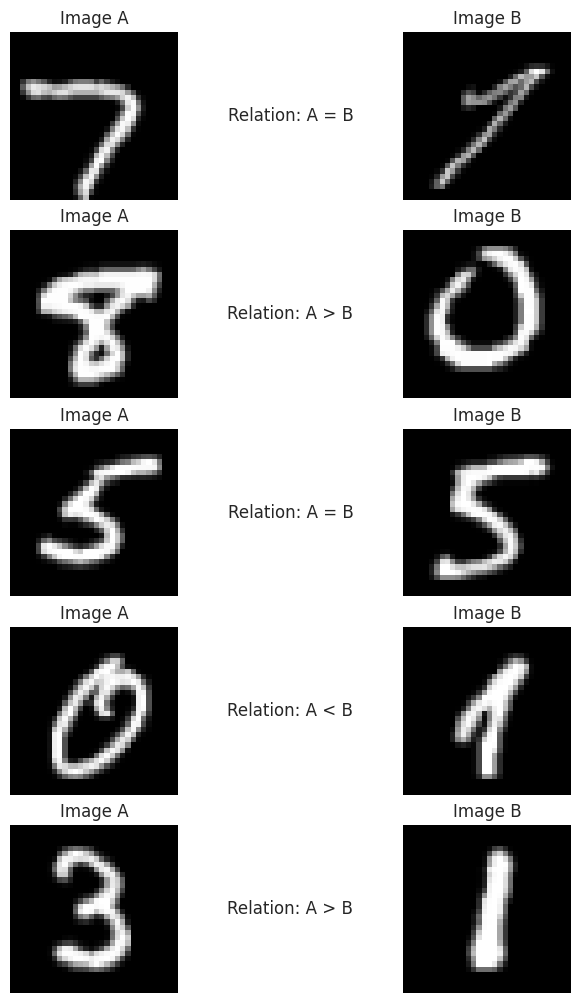

In [12]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [13]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [14]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


Loss: 0.5120: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]


Validating


Loss: 0.5488: 100%|██████████| 55/55 [00:00<00:00, 60.28it/s]


Epoch #1 train loss: 0.656 train accuracy: 71.36
Epoch #1 validation loss: 0.549 validation accuracy: 79.97
Learning rate actual:  0.005
Took 0.271 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.3419: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]


Validating


Loss: 0.4567: 100%|██████████| 55/55 [00:01<00:00, 44.51it/s]


Epoch #2 train loss: 0.441 train accuracy: 82.47
Epoch #2 validation loss: 0.457 validation accuracy: 85.41
Learning rate actual:  0.005
Took 0.313 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.2453: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]


Validating


Loss: 0.5330: 100%|██████████| 55/55 [00:01<00:00, 53.32it/s]


Epoch #3 train loss: 0.357 train accuracy: 86.32
Epoch #3 validation loss: 0.533 validation accuracy: 86.31
Learning rate actual:  0.005
Took 0.312 minutes for epoch 3
No improvement for 1 epoch(s).
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.3386: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]


Validating


Loss: 0.3932: 100%|██████████| 55/55 [00:01<00:00, 53.44it/s]


Epoch #4 train loss: 0.308 train accuracy: 88.29
Epoch #4 validation loss: 0.393 validation accuracy: 88.86
Learning rate actual:  0.005
Took 0.310 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.2186: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]


Validating


Loss: 0.2914: 100%|██████████| 55/55 [00:01<00:00, 49.64it/s]


Epoch #5 train loss: 0.270 train accuracy: 90.02
Epoch #5 validation loss: 0.291 validation accuracy: 90.58
Learning rate actual:  0.005
Took 0.309 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.2141: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]


Validating


Loss: 0.2577: 100%|██████████| 55/55 [00:00<00:00, 60.59it/s]


Epoch #6 train loss: 0.244 train accuracy: 91.06
Epoch #6 validation loss: 0.258 validation accuracy: 89.88
Learning rate actual:  0.005
Took 0.316 minutes for epoch 6
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.1110: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]


Validating


Loss: 0.3481: 100%|██████████| 55/55 [00:00<00:00, 73.46it/s]


Epoch #7 train loss: 0.220 train accuracy: 92.03
Epoch #7 validation loss: 0.348 validation accuracy: 92.14
Learning rate actual:  0.005
Took 0.279 minutes for epoch 7
No improvement for 1 epoch(s).
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.1971: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]


Validating


Loss: 0.2857: 100%|██████████| 55/55 [00:00<00:00, 55.36it/s]


Epoch #8 train loss: 0.200 train accuracy: 92.72
Epoch #8 validation loss: 0.286 validation accuracy: 92.24
Learning rate actual:  0.005
Took 0.308 minutes for epoch 8
No improvement for 2 epoch(s).
Checkpoint saved at epoch 8.

EPOCH 9 of 30
Training


Loss: 0.1590: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]


Validating


Loss: 0.2674: 100%|██████████| 55/55 [00:01<00:00, 51.37it/s]


Epoch #9 train loss: 0.189 train accuracy: 93.17
Epoch #9 validation loss: 0.267 validation accuracy: 92.73
Learning rate actual:  0.005
Took 0.300 minutes for epoch 9
No improvement for 3 epoch(s).
Checkpoint saved at epoch 9.

EPOCH 10 of 30
Training


Loss: 0.2707: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]


Validating


Loss: 0.3111: 100%|██████████| 55/55 [00:00<00:00, 57.28it/s]


Epoch #10 train loss: 0.174 train accuracy: 93.75
Epoch #10 validation loss: 0.311 validation accuracy: 93.07
Learning rate actual:  0.005
Took 0.287 minutes for epoch 10
No improvement for 4 epoch(s).
Checkpoint saved at epoch 10.

EPOCH 11 of 30
Training


Loss: 0.1492: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]


Validating


Loss: 0.2148: 100%|██████████| 55/55 [00:00<00:00, 55.32it/s]


Epoch #11 train loss: 0.165 train accuracy: 94.02
Epoch #11 validation loss: 0.215 validation accuracy: 93.27
Learning rate actual:  0.005
Took 0.300 minutes for epoch 11
Checkpoint saved at epoch 11.

EPOCH 12 of 30
Training


Loss: 0.2338: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]


Validating


Loss: 0.1476: 100%|██████████| 55/55 [00:00<00:00, 61.78it/s]


Epoch #12 train loss: 0.158 train accuracy: 94.33
Epoch #12 validation loss: 0.148 validation accuracy: 93.26
Learning rate actual:  0.005
Took 0.295 minutes for epoch 12
Checkpoint saved at epoch 12.

EPOCH 13 of 30
Training


Loss: 0.2109: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]


Validating


Loss: 0.2095: 100%|██████████| 55/55 [00:00<00:00, 60.53it/s]


Epoch #13 train loss: 0.150 train accuracy: 94.54
Epoch #13 validation loss: 0.209 validation accuracy: 92.61
Learning rate actual:  0.005
Took 0.279 minutes for epoch 13
No improvement for 1 epoch(s).
Checkpoint saved at epoch 13.

EPOCH 14 of 30
Training


Loss: 0.1367: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]


Validating


Loss: 0.2165: 100%|██████████| 55/55 [00:01<00:00, 54.90it/s]


Epoch #14 train loss: 0.147 train accuracy: 94.77
Epoch #14 validation loss: 0.216 validation accuracy: 93.44
Learning rate actual:  0.005
Took 0.301 minutes for epoch 14
No improvement for 2 epoch(s).
Checkpoint saved at epoch 14.

EPOCH 15 of 30
Training


Loss: 0.1403: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]


Validating


Loss: 0.1338: 100%|██████████| 55/55 [00:00<00:00, 56.86it/s]


Epoch #15 train loss: 0.140 train accuracy: 95.10
Epoch #15 validation loss: 0.134 validation accuracy: 93.58
Learning rate actual:  0.005
Took 0.303 minutes for epoch 15
Checkpoint saved at epoch 15.

EPOCH 16 of 30
Training


Loss: 0.1215: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]


Validating


Loss: 0.1190: 100%|██████████| 55/55 [00:01<00:00, 51.78it/s]


Epoch #16 train loss: 0.138 train accuracy: 95.18
Epoch #16 validation loss: 0.119 validation accuracy: 93.91
Learning rate actual:  0.005
Took 0.302 minutes for epoch 16
Checkpoint saved at epoch 16.

EPOCH 17 of 30
Training


Loss: 0.0927: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]


Validating


Loss: 0.2227: 100%|██████████| 55/55 [00:00<00:00, 67.08it/s]


Epoch #17 train loss: 0.130 train accuracy: 95.48
Epoch #17 validation loss: 0.223 validation accuracy: 93.61
Learning rate actual:  0.005
Took 0.273 minutes for epoch 17
No improvement for 1 epoch(s).
Checkpoint saved at epoch 17.

EPOCH 18 of 30
Training


Loss: 0.2373: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]


Validating


Loss: 0.1201: 100%|██████████| 55/55 [00:00<00:00, 55.87it/s]


Epoch #18 train loss: 0.131 train accuracy: 95.34
Epoch #18 validation loss: 0.120 validation accuracy: 93.78
Learning rate actual:  0.005
Took 0.308 minutes for epoch 18
No improvement for 2 epoch(s).
Checkpoint saved at epoch 18.

EPOCH 19 of 30
Training


Loss: 0.0668: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]


Validating


Loss: 0.1789: 100%|██████████| 55/55 [00:01<00:00, 47.37it/s]


Epoch #19 train loss: 0.127 train accuracy: 95.52
Epoch #19 validation loss: 0.179 validation accuracy: 94.08
Learning rate actual:  0.005
Took 0.317 minutes for epoch 19
No improvement for 3 epoch(s).
Checkpoint saved at epoch 19.

EPOCH 20 of 30
Training


Loss: 0.1318: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]


Validating


Loss: 0.1918: 100%|██████████| 55/55 [00:00<00:00, 64.57it/s]


Epoch #20 train loss: 0.125 train accuracy: 95.69
Epoch #20 validation loss: 0.192 validation accuracy: 94.30
Learning rate actual:  0.005
Took 0.297 minutes for epoch 20
No improvement for 4 epoch(s).
Checkpoint saved at epoch 20.

EPOCH 21 of 30
Training


Loss: 0.0544: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]


Validating


Loss: 0.1290: 100%|██████████| 55/55 [00:00<00:00, 60.94it/s]


Epoch #21 train loss: 0.120 train accuracy: 95.81
Epoch #21 validation loss: 0.129 validation accuracy: 93.96
Learning rate actual:  0.005
Took 0.285 minutes for epoch 21
No improvement for 5 epoch(s).
Early stopping triggered after 21 epochs.
Checkpoint saved at epoch 21.
Validating


Loss: 0.0662: 100%|██████████| 24/24 [00:00<00:00, 43.83it/s]

Test loss: 0.066 Test accuracy: 94.40


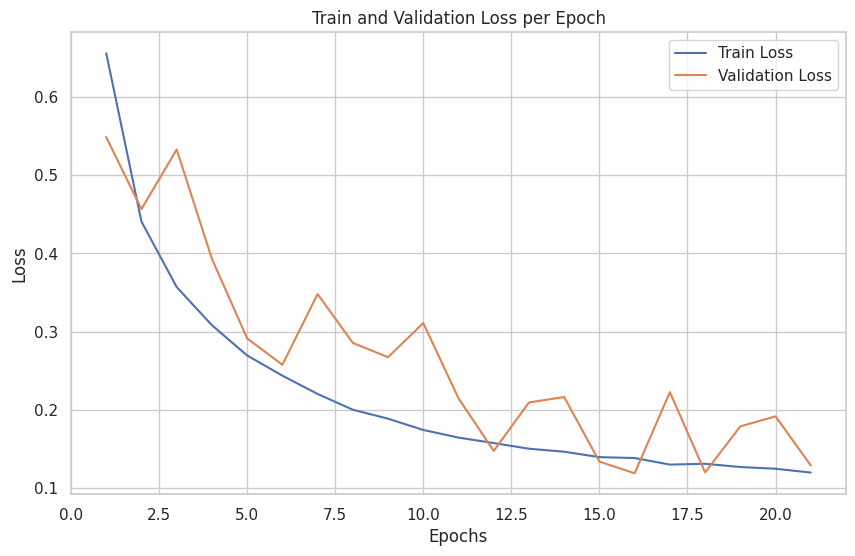

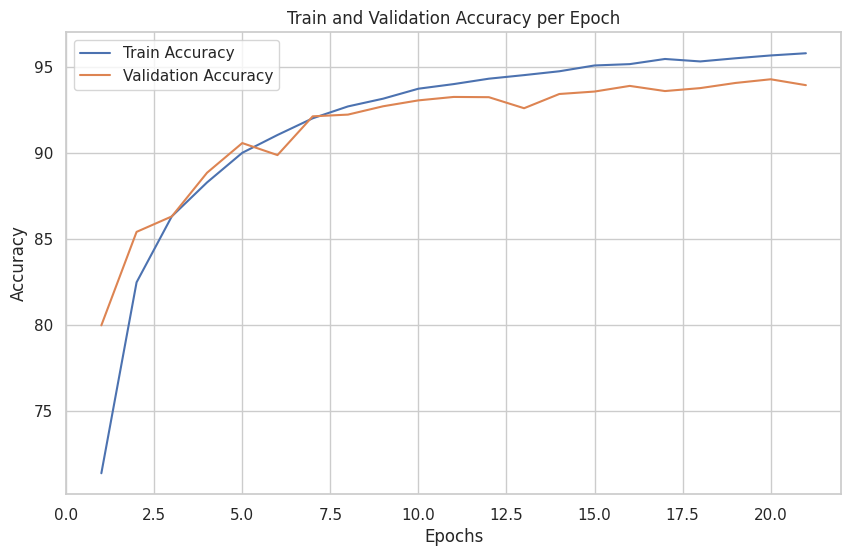

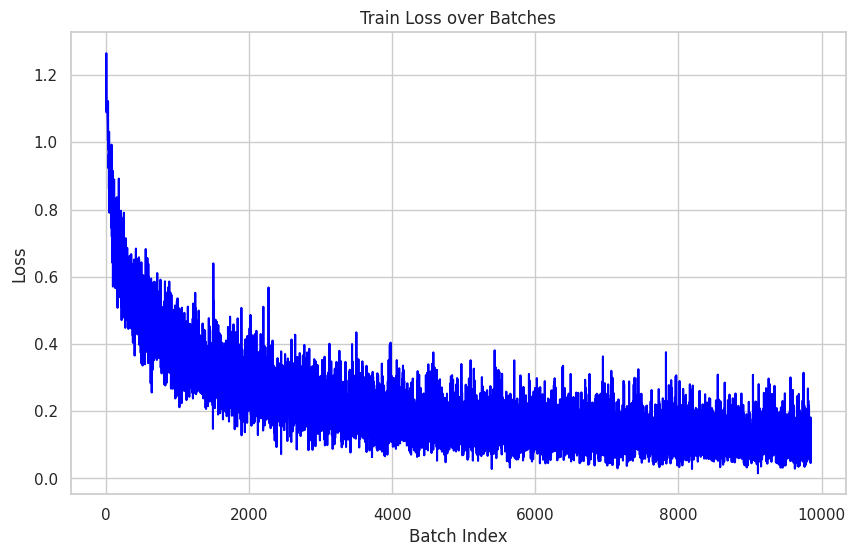

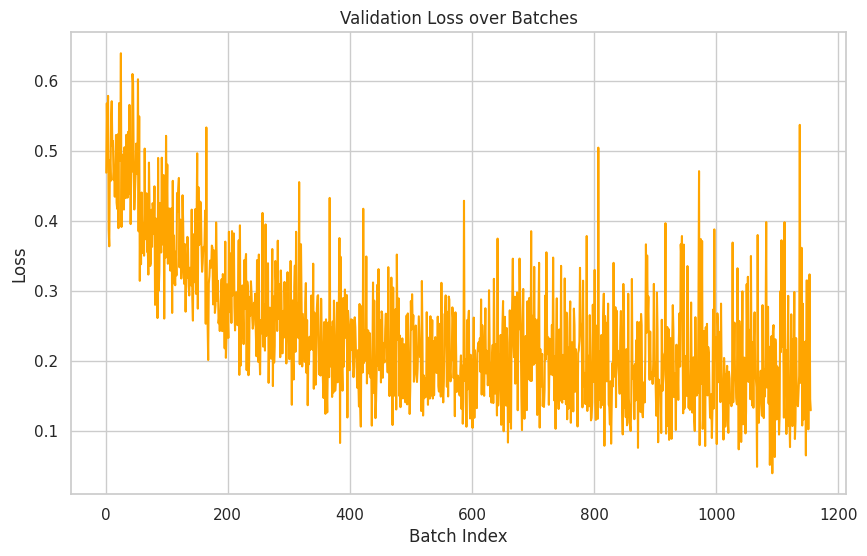

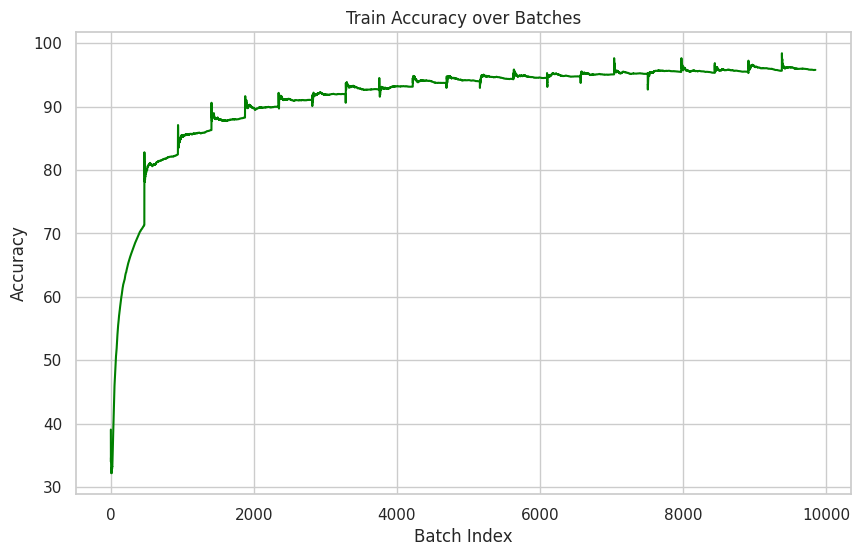

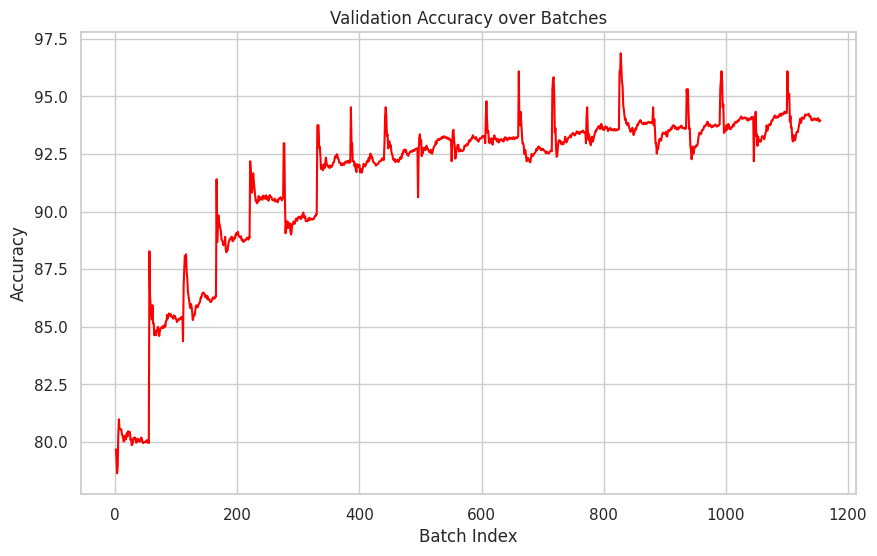

In [15]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

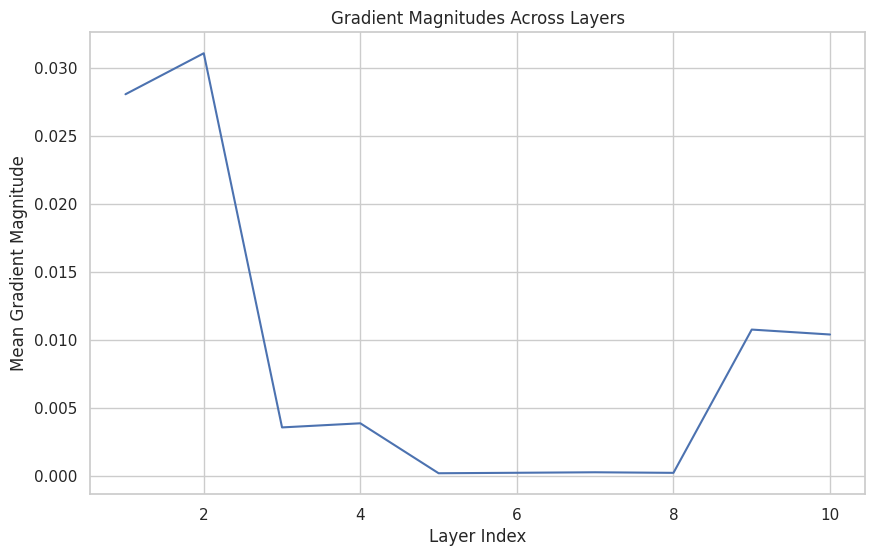

In [16]:
utils.plot_gradient(model)

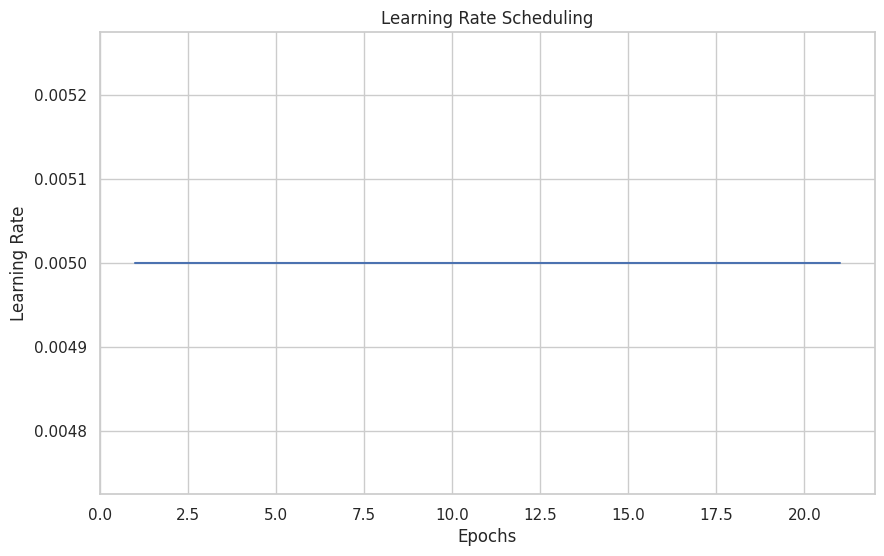

In [17]:
utils.plot_lr_scheduler(lr_history)

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions', utils.show_incorrect_predictions(model, validation_loader, device, num_images=10))
#show_incorrect_predictions(model, validation_loader, num_images=5)

423 previsioni errate trovate.


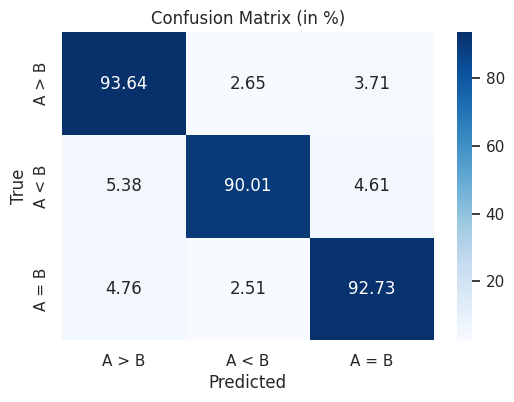

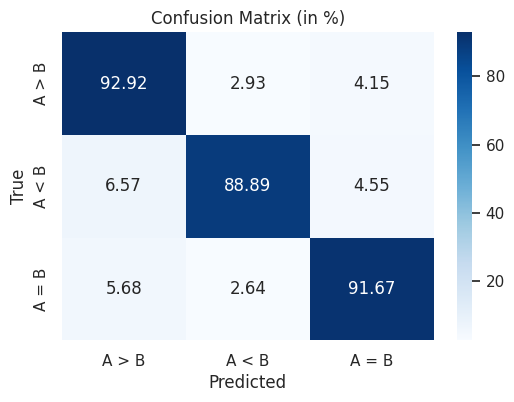

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(model, validation_loader, device))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(model, test_loader, device))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(model, test_loader, device)


              precision    recall  f1-score   support

       A > B       0.88      0.93      0.90       989
       A < B       0.94      0.89      0.91       990
       A = B       0.92      0.92      0.92      1021

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32.ipynb')


Notebook saved as run32x32_BS=128_LR=0.0015_MOM=0.9_EPOCHS=20_AUG=False_TRA=False_OPT=SGD.ipynb


In [ ]:
writer.close()